In [1]:
import pandas as pd
import numpy as np

In [2]:
from corpus_reading import read_dump
import corpus_utils

chords_tsv = 'data/chord_list.tsv'
notes_tsv = 'data/note_list.tsv'
measures_tsv = 'data/measure_list.tsv'
files_tsv = 'data/file_list.tsv'

chords_df = read_dump(chords_tsv)
notes_df = read_dump(notes_tsv, index_col=[0,1,2])
measures_df = read_dump(measures_tsv)
files_df = read_dump(files_tsv, index_col=0)

# Bugfixes
measures_df.loc[(685, 487), 'next'][0] = 488

In [3]:
files_df

,extension,filename,md5,name,rel_path,subcorpus
id,,,,,,
0,.mscx,BWV806_01_Prélude.mscx,e81d2b409a3c696e733ac86b86f522ee,BWV806_01_Prélude,annotations/Bach_Suites/English Suites,English Suites
1,.mscx,BWV806_02_Allemande.mscx,891f360ce282304a05b6172a67961b1a,BWV806_02_Allemande,annotations/Bach_Suites/English Suites,English Suites
2,.mscx,BWV806_03_Courante_I.mscx,30885cb1c729ef726e7d7f6dbb96c71b,BWV806_03_Courante_I,annotations/Bach_Suites/English Suites,English Suites
3,.mscx,BWV806_04_Courante_II.mscx,10f21162c887d978f95ffdd34c03bc50,BWV806_04_Courante_II,annotations/Bach_Suites/English Suites,English Suites
4,.mscx,BWV806_05_Double_I.mscx,afe9dccb3ee6a23457c84450fdf33a65,BWV806_05_Double_I,annotations/Bach_Suites/English Suites,English Suites
...,...,...,...,...,...,...
692,.mscx,n15op132_05.mscx,99de9a044640c174120817a0126f74cc,n15op132_05,data/mscx,mscx
693,.mscx,n16op135_01.mscx,a60fdfa4c0a2a9b80f0884859fbb4ae4,n16op135_01,data/mscx,mscx
694,.mscx,n16op135_02.mscx,196149b8165016829d4075e0b6dc617b,n16op135_02,data/mscx,mscx


In [4]:
chords_df

mc   mn onset chords  chord key pedal numeral  form figbass  \
id  chord_id                                                                 
0   0           0    1     0   .A.I      I   I  <NA>       I  <NA>    <NA>   
    1           0    1   3/8     V7     V7   I  <NA>       V  <NA>       7   
    2           0    1   3/4      I      I   I  <NA>       I  <NA>    <NA>   
    3           0    1   9/8     V7     V7   I  <NA>       V  <NA>       7   
    4           1    2     0      I      I   I  <NA>       I  <NA>    <NA>   
...           ...  ...   ...    ...    ...  ..   ...     ...   ...     ...   
696 160058    280  281   1/2      I      I   I  <NA>       I  <NA>    <NA>   
    160059    280  281   3/4     I6     I6   I  <NA>       I  <NA>       6   
    160060    281  282     0  V(64)  V(64)   I  <NA>       V  <NA>    <NA>   
    160061    281  282   1/2     V7     V7   I  <NA>       V  <NA>       7   
    160062    282  283     0    I\\      I   I  <NA>       I  <NA>    <NA>   

              ... relativeroot phraseend globalkey bass_step mc_next  \
id  chord_id  ...                                                      
0   0         ...         <NA>      <NA>         A         1       0   
    1         ...         <NA>      <NA>         A         5       0   
    2         ...         <NA>      <NA>         A         1       0   
    3         ...         <NA>      <NA>         A         5       1   
    4         ...         <NA>      <NA>         A         1       1   
...           ...          ...       ...       ...       ...     ...   
696 160058    ...         <NA>      <NA>         f         1     280   
    160059    ...         <NA>      <NA>         f         3     281   
    160060    ...         <NA>      <NA>         f         5     281   
    160061    ...         <NA>      <NA>         f         5     282   
    160062    ...         <NA>        \\         f         1     283   

              onset_next next_chord_id  chord_length globalminor  localminor  
id  chord_id                                                                  
0   0                3/8             1           3/8       False       False  
    1                3/4             2           3/8       False       False  
    2                9/8             3           3/8       False       False  
    3                  0             4           3/8       False       False  
    4                3/8             5           3/8       False       False  
...                  ...           ...           ...         ...         ...  
696 160058           3/4        160059           1/4        True       False  
    160059             0        160060           1/4        True       False  
    160060           1/2        160061           1/2        True       False  
    160061             0        160062           1/2        True       False  
    160062             0          <NA>             1        True       False  

[142511 rows x 21 columns]

In [5]:
measures_df

section  keysig timesig duration act_dur offset  voices  \
id  mc                                                             
0   0          0       3    12/8      3/2     3/2      0       4   
    1          0       3    12/8      3/2     3/2      0       5   
    2          0       3    12/8      3/2     3/2      0       6   
    3          0       3    12/8      3/2     3/2      0       3   
    4          0       3    12/8      3/2     3/2      0       4   
...          ...     ...     ...      ...     ...    ...     ...   
696 278       13      -1     4/4        1       1      0       4   
    279       13      -1     4/4        1       1      0       4   
    280       13      -1     4/4        1       1      0       4   
    281       13      -1     4/4        1       1      0       4   
    282       13      -1     4/4        1       1      0       4   

              repeats  volta barline  numbering_offset  dont_count marker  \
id  mc                                                                      
0   0    firstMeasure   <NA>    <NA>              <NA>        <NA>   <NA>   
    1            <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    2            <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    3            <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    4            <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
...               ...    ...     ...               ...         ...    ...   
696 278          <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    279          <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    280          <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    281          <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    282   lastMeasure   <NA>     end              <NA>        <NA>   <NA>   

          mn   next  
id  mc               
0   0      1    [1]  
    1      2    [2]  
    2      3    [3]  
    3      4    [4]  
    4      5    [5]  
...      ...    ...  
696 278  279  [279]  
    279  280  [280]  
    280  281  [281]  
    281  282  [282]  
    282  283     []  

[75318 rows x 15 columns]

In [6]:
notes_df

mc   mn onset duration gracenote nominal_duration scalar  \
id  section ix                                                               
0   0       0      0    1     0     1/16      <NA>             1/16      1   
            1      0    1  1/16     1/16      <NA>             1/16      1   
            2      0    1   1/8     1/16      <NA>             1/16      1   
            3      0    1  3/16     1/16      <NA>             1/16      1   
            4      0    1   1/4     1/16      <NA>             1/16      1   
...              ...  ...   ...      ...       ...              ...    ...   
696 13      309  282  283     0      1/4      <NA>              1/4      1   
            310  282  283     0      1/4      <NA>              1/4      1   
            311  282  283     0      1/4      <NA>              1/4      1   
            312  282  283     0      1/4      <NA>              1/4      1   
            313  282  283     0      1/4      <NA>              1/4      1   

                 tied  tpc  midi  staff  voice  volta  octaves note_names  \
id  section ix                                                              
0   0       0    <NA>    3    45      2      2   <NA>        2          A   
            1    <NA>    7    49      2      2   <NA>        3         C#   
            2    <NA>    4    52      2      2   <NA>        3          E   
            3    <NA>    3    57      2      1   <NA>        3          A   
            4    <NA>    8    56      2      1   <NA>        3         G#   
...               ...  ...   ...    ...    ...    ...      ...        ...   
696 13      309  <NA>   -1    53      3      1   <NA>        3          F   
            310  <NA>    3    69      1      1   <NA>        4          A   
            311  <NA>    3    69      2      1   <NA>        4          A   
            312  <NA>   -1    77      2      1   <NA>        5          F   
            313  <NA>   -1    89      1      1   <NA>        6          F   

                 keysig timesig  beats  
id  section ix                          
0   0       0         3    12/8      1  
            1         3    12/8  1.1/6  
            2         3    12/8  1.1/3  
            3         3    12/8  1.1/2  
            4         3    12/8  1.2/3  
...                 ...     ...    ...  
696 13      309      -1     4/4      1  
            310      -1     4/4      1  
            311      -1     4/4      1  
            312      -1     4/4      1  
            313      -1     4/4      1  

[1079574 rows x 18 columns]

In [7]:
import harmonic_inference_data as hid
import importlib
importlib.reload(hid)

datasets = {'global': {},
            'local': {},
            'none': {}}

datasets['global']['train'], datasets['global']['valid'], datasets['global']['test'] = hid.get_train_valid_test_splits(
    chords_df=chords_df, notes_df=notes_df, measures_df=measures_df, files_df=files_df,
    seed=0, h5_directory='data', h5_prefix='globalkey_811split', make_dfs=True, transpose_global=True
)

datasets['local']['train'], datasets['local']['valid'], datasets['local']['test'] = hid.get_train_valid_test_splits(
    chords_df=chords_df, notes_df=notes_df, measures_df=measures_df, files_df=files_df,
    seed=0, h5_directory='data', h5_prefix='localkey_811split', make_dfs=True, transpose_local=True
)

datasets['none']['train'], datasets['none']['valid'], datasets['none']['test'] = hid.get_train_valid_test_splits(
    chords_df=chords_df, notes_df=notes_df, measures_df=measures_df, files_df=files_df,
    seed=0, h5_directory='data', h5_prefix='811split', make_dfs=True
)

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (0, 0, 105) and duration 5/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (0, 0, 446) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (1, 0, 233) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (1, 0, 359) and duration 1/8. Returning None.
  warnings.war

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (230, 0, 199) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (230, 0, 200) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (233, 0, 1605) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (238, 0, 197) and duration 1/8. Returning None.
  war

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (283, 0, 111) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (284, 1, 31) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (284, 1, 348) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (284, 1, 350) and duration 3/4. Returning None.
  warnin

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (306, 0, 37) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (306, 0, 126) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (306, 3, 29) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (306, 3, 118) and duration 1/4. Returning None.
  warning

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (392, 0, 537) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (392, 0, 930) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (392, 1, 214) and duration 11/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (392, 2, 54) and duration 1/8. Returning None.
  warn

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2222) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2223) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2224) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2225) and duration 3/4. Returning None.
  w

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (610, 0, 299) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (610, 1, 290) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (612, 1, 904) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (612, 1, 963) and duration 1/2. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (635, 0, 1) and duration 1. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (635, 1, 1988) and duration 5/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (642, 3, 137) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (645, 8, 249) and duration 1/8. Returning None.
  warnings

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 2, 146) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 2, 147) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 3, 262) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 3, 263) and duration 1/4. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 259) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 294) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 332) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 361) and duration 1/2. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (653, 0, 1432) and duration 1/32. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (674, 0, 612) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (680, 3, 679) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (680, 3, 682) and duration 1/2. Returning None.
  war

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (492, 3, 239) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (492, 7, 52) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (551, 0, 133) and duration 1. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (626, 0, 1286) and duration 1/16. Returning None.
  warnin

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (129, 1, 106) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (129, 1, 108) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (140, 0, 105) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (155, 0, 81) and duration 1/4. Returning None.
  warnin

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (273, 0, 887) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (273, 0, 1476) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (278, 0, 83) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (280, 0, 52) and duration 3/8. Returning None.
  warnin

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (286, 6, 60) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (286, 8, 111) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (287, 0, 625) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (287, 0, 1231) and duration 1/4. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (366, 0, 1004) and duration 1/32. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (366, 0, 1005) and duration 1/32. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (366, 0, 1006) and duration 1/32. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (366, 0, 1038) and duration 1/32. Returning None.

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (387, 3, 653) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (387, 3, 1056) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (388, 0, 107) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (388, 1, 9) and duration 5/4. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (441, 0, 106) and duration 3/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (451, 0, 580) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (460, 15, 131) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (502, 1, 34) and duration 1/40. Returning None.
  war

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2222) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2223) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2224) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2225) and duration 3/4. Returning None.
  w

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (610, 0, 299) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (610, 1, 290) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (612, 1, 904) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (612, 1, 963) and duration 1/2. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (635, 0, 1) and duration 1. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (635, 1, 1988) and duration 5/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (642, 3, 137) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (645, 8, 249) and duration 1/8. Returning None.
  warnings

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 2, 146) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 2, 147) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 3, 262) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 3, 263) and duration 1/4. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 259) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 294) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 332) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 361) and duration 1/2. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (674, 0, 612) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (680, 3, 679) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (680, 3, 682) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (680, 8, 2475) and duration 3/2. Returning None.
  warn

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (492, 3, 239) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (492, 7, 52) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (551, 0, 133) and duration 1. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (626, 0, 1286) and duration 1/16. Returning None.
  warnin

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (129, 1, 106) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (129, 1, 108) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (140, 0, 105) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (155, 0, 81) and duration 1/4. Returning None.
  warnin

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (273, 0, 887) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (273, 0, 1476) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (278, 0, 83) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (280, 0, 52) and duration 3/8. Returning None.
  warnin

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (286, 1, 111) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (286, 6, 60) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (286, 8, 111) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (287, 0, 625) and duration 1/4. Returning None.
  warnin

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (306, 0, 37) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (306, 0, 126) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (306, 3, 29) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (306, 3, 118) and duration 1/4. Returning None.
  warning

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (392, 0, 14) and duration 3/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (392, 0, 137) and duration 3/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (392, 0, 473) and duration 3/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (392, 0, 537) and duration 1/16. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2222) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2223) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2224) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (503, 1, 2225) and duration 3/4. Returning None.
  w

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (610, 0, 299) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (610, 1, 290) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (612, 1, 904) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (612, 1, 963) and duration 1/2. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (635, 0, 1) and duration 1. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (635, 1, 1988) and duration 5/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (642, 3, 137) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (645, 8, 249) and duration 1/8. Returning None.
  warnings

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (675, 0, 1793) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 2, 146) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 2, 147) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (681, 3, 262) and duration 1/4. Returning None.
  warn

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 259) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 294) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 332) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (373, 1, 361) and duration 1/2. Returning None.
  warni

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (674, 0, 612) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (680, 3, 679) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (680, 3, 682) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (680, 8, 2475) and duration 3/2. Returning None.
  warn

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (492, 3, 239) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (492, 7, 52) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (551, 0, 133) and duration 1. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:427: UserWarning: No matching tied note found for note index (626, 0, 1286) and duration 1/16. Returning None.
  warnin

In [8]:
import harmonic_inference_models as him
import harmonic_utils
import importlib
importlib.reload(him)
from ablation import get_masks_and_names
import torch
import os

masks, mask_names = get_masks_and_names()
dir_name = 'results'

data = 'local'
index = -1
prefix = (data + '_') if data != 'none' else ''

mask = torch.tensor(masks[index])
mask_name = mask_names[index]
checkpoint_dir = os.path.join(dir_name, prefix + mask_name)
log_file_name = os.path.join(dir_name, prefix + mask_name + '.log')

model = him.MusicScoreModel(len(datasets[data]['test'][0]['notes'][0]), len(harmonic_utils.CHORD_TYPES) * 12,
                            dropout=0.2, input_mask=mask)

print(mask_name)
print(checkpoint_dir)

no_ablation
results/local_no_ablation


In [12]:
import os
import model_trainer
import importlib
importlib.reload(model_trainer)

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
criterion = CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
schedule_var = 'valid_loss'

trainer = model_trainer.ModelTrainer(model, train_dataset=datasets[data]['train'], valid_dataset=datasets[data]['valid'],
                                     test_dataset=datasets[data]['test'], seed=0, num_epochs=100, early_stopping=20,
                                     optimizer=optimizer, scheduler=scheduler, schedule_var=schedule_var,
                                     criterion=criterion,
                                     log_every=1, log_file_name=log_file_name,
                                     save_every=10, save_dir=checkpoint_dir, save_prefix='checkpoint',
                                     resume=os.path.join(checkpoint_dir, 'best.pth.tar'))

In [ ]:
trainer.train()

In [13]:
trainer = model_trainer.ModelTrainer(model, train_dataset=datasets[data]['train'], valid_dataset=datasets[data]['valid'],
                                     test_dataset=datasets[data]['test'], seed=0, num_epochs=100, early_stopping=20,
                                     optimizer=optimizer, scheduler=scheduler, schedule_var=schedule_var,
                                     criterion=criterion,
                                     log_every=1, log_file_name=log_file_name,
                                     save_every=10, save_dir=checkpoint_dir, save_prefix='checkpoint',
                                     resume=os.path.join(checkpoint_dir, 'best.pth.tar'))

loss, acc, outputs, labels = trainer.evaluate(valid=False)
print(loss, acc)

1.4203217774499604 0.5985751672864272


/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/eval_utils.py:41: RuntimeWarning: invalid value encountered in true_divide
  conf_mat /= np.sum(conf_mat, axis=1, keepdims=True)


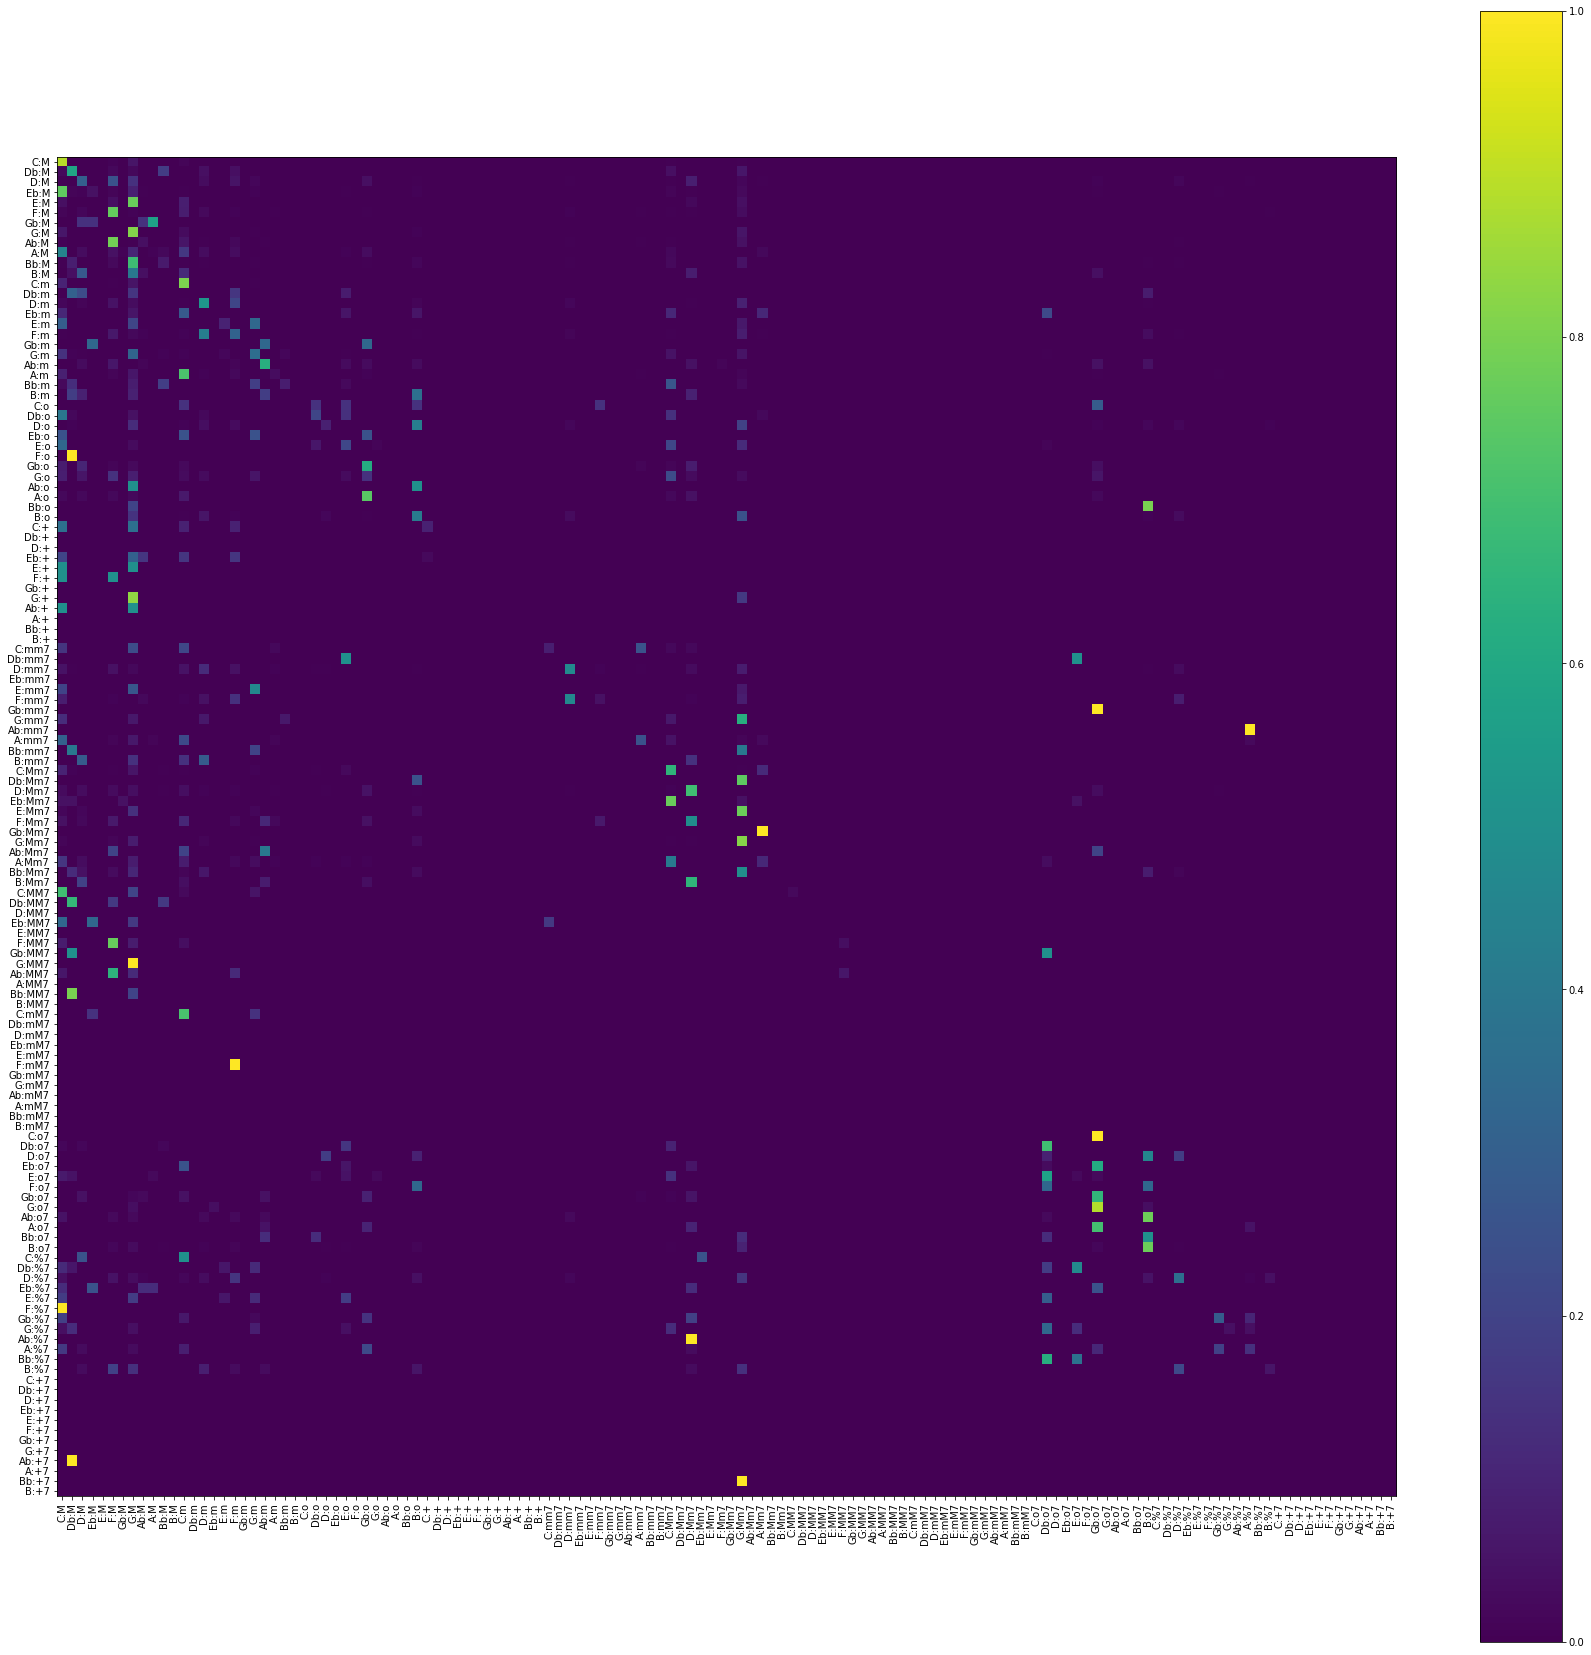

In [14]:
import eval_utils as eu
import harmonic_utils as hu
import matplotlib.pyplot as plt

label_strings = hu.get_one_hot_labels()
conf_mat = eu.get_conf_mat(labels, outputs)

plt.figure(figsize=(30,30))
plt.imshow(conf_mat, interpolation='none')
plt.colorbar()
plt.xticks(ticks=list(range(len(label_strings))), labels=label_strings, rotation=90, fontsize=10)
plt.yticks(ticks=list(range(len(label_strings))), labels=label_strings, fontsize=10)
plt.show()

In [15]:
import eval_utils as eu

correct, incorrect = eu.get_correct_and_incorrect_indexes(labels, outputs)
print('Correct: ' + str(len(correct)))
print('Incorrect: ' + str(len(incorrect)))

Correct: 8234
Incorrect: 5522


In [16]:
import eval_utils as eu
    
eu.print_result(incorrect[0], labels, outputs, limit=10, prob=False)

Correct: 0 (C:M)
Guessed: 12 (C:m)
C:m: 7.490598678588867
A:m: 6.260463237762451
C:M: 5.661648273468018
F:M: 5.519595146179199
G:M: 5.312853813171387
Ab:M: 4.606175422668457
B:o: 3.3627429008483887
A:mm7: 3.305283784866333
A:o: 2.986206531524658
F:m: 2.959134578704834


In [17]:
import eval_utils as eu

chord, onset_notes, all_notes = eu.get_input_df_rows(incorrect[0], datasets[data]['test'])

print(chord)
print("USED NOTES:")
print(onset_notes)
print()
print("ALL NOTES:")
print(all_notes)

mc                   1
mn                   1
onset                0
chords               I
chord                I
key                  I
pedal             <NA>
numeral              I
form              <NA>
figbass           <NA>
changes           <NA>
relativeroot      <NA>
phraseend         <NA>
globalkey            A
bass_step            1
mc_next              1
onset_next         1/4
next_chord_id     1248
chord_length       1/4
globalminor      False
localminor       False
Name: (9, 1247), dtype: object
USED NOTES:
            mc  mn onset duration gracenote nominal_duration scalar  tied  \
section ix                                                                  
0       1    1   1     0      1/8      <NA>              1/8      1  <NA>   
        2    1   1   1/8     1/16      <NA>             1/16      1  <NA>   
        3    1   1  3/16     1/16      <NA>             1/16      1  <NA>   

            tpc  midi  ...  note_names  keysig  timesig  beats offset_mc  \
section ix  

<BarContainer object of 132 artists>

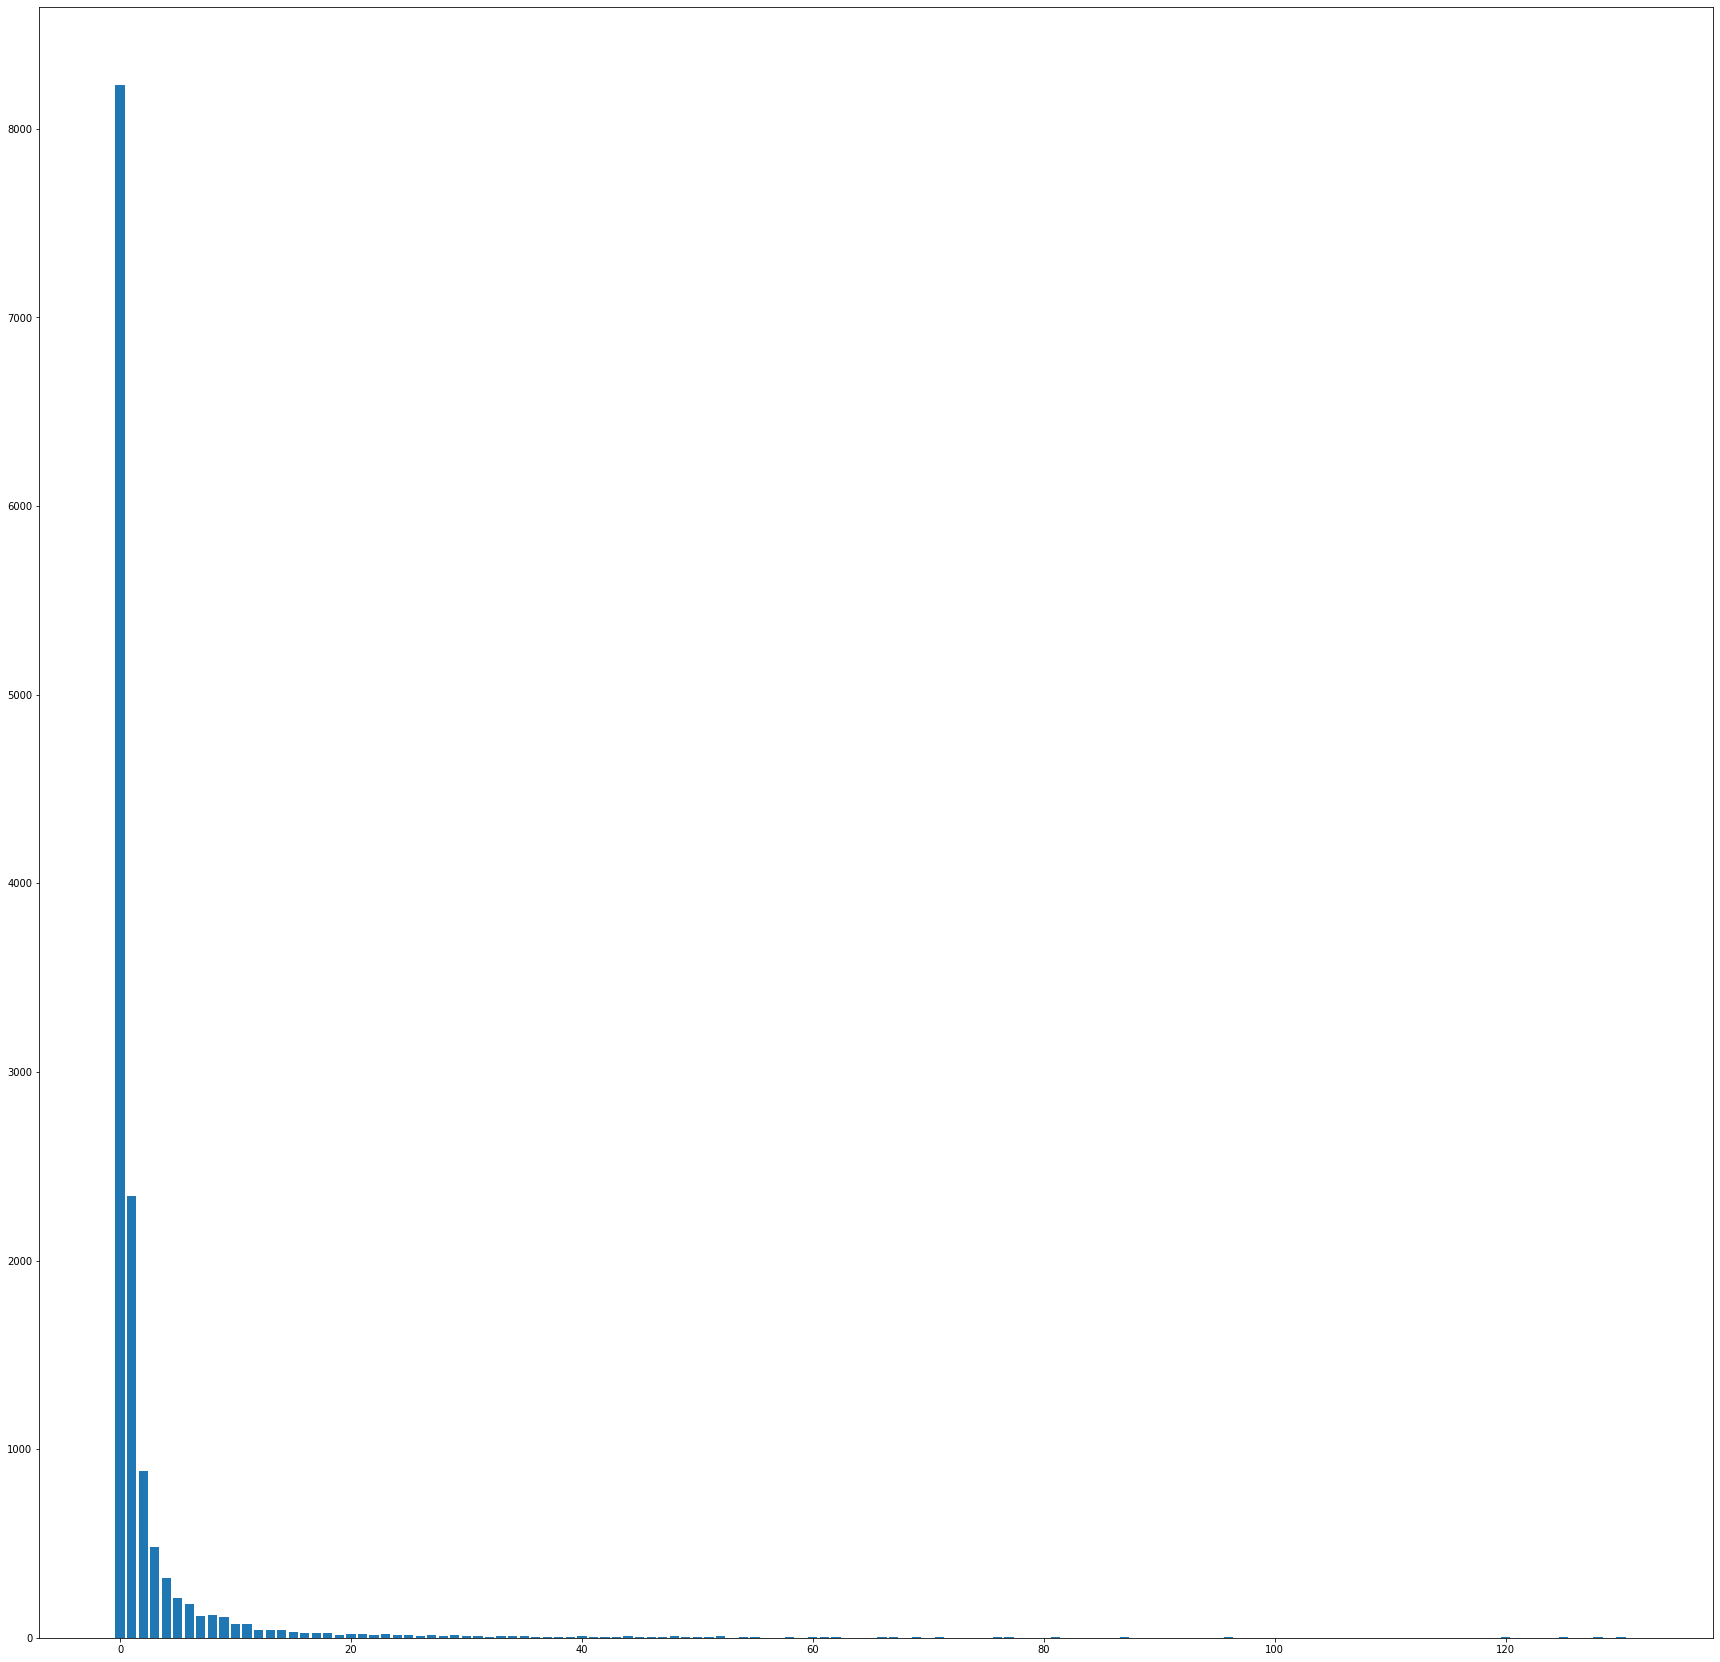

In [18]:
import matplotlib.pyplot as plt
import eval_utils as eu

correct_ranks, indexes_by_rank = eu.get_correct_ranks(labels, outputs)
    
plt.figure(figsize=(30,30))
plt.bar(range(len(outputs[0])), [len(indexes) for indexes in indexes_by_rank])

In [ ]:
import eval_utils as eu
import importlib
importlib.reload(eu)

eval_df = eu.get_eval_df(labels, outputs, datasets[data]['test'])
eval_df

In [ ]:
import ablation
import importlib
importlib.reload(ablation)

dfs = ablation.load_all_ablated_dfs(directory='results', prefix=prefix[:-1] if len(prefix) > 0 else None)
_, mask_names = ablation.get_masks_and_names()

In [21]:
import pandas as pd
import os

logs = []
for mask_name in mask_names:
    logs.append(pd.read_csv(os.path.join(os.path.join('results', prefix + mask_name + '.log'))))

In [22]:
for df, log, mask_name in zip(dfs, logs, mask_names):
    print(f"{mask_name} Acc: {100 * df.correct.sum() / len(df)}")
    print(log.iloc[-1])

no_rhythm Acc: 58.12736260540855
epoch         65.000000
train_loss     1.434294
train_acc      0.593453
valid_loss     1.704687
valid_acc      0.516600
Name: 65, dtype: float64
no_levels Acc: 53.42396045362024
epoch         95.000000
train_loss     1.415247
train_acc      0.598285
valid_loss     1.691001
valid_acc      0.518800
Name: 95, dtype: float64
no_chord-relative_rhythm Acc: 58.83250945042163
epoch         67.000000
train_loss     1.405957
train_acc      0.601539
valid_loss     1.695943
valid_acc      0.520502
Name: 67, dtype: float64
no_lowest Acc: 53.496656004652515
epoch         64.000000
train_loss     1.394936
train_acc      0.604513
valid_loss     1.685411
valid_acc      0.522701
Name: 64, dtype: float64
no_octave Acc: 52.973248037220124
epoch         87.000000
train_loss     1.394462
train_acc      0.603998
valid_loss     1.677390
valid_acc      0.526958
Name: 87, dtype: float64
no_ablation Acc: 59.857516719976736
epoch         95.000000
train_loss     1.382635
train_acc

In [10]:
import eval_utils as eu

global_df = eu.load_eval_df('results/global_no_ablation.csv')
local_df = eu.load_eval_df('results/local_no_ablation.csv')
none_df = eu.load_eval_df('results/no_ablation.csv')

In [17]:
global_df

,rank,correct,correct_chord,correct_root,correct_type,guessed_chord,guessed_root,guessed_type,num_notes,chord_onset_level,chord_offset_level,chord_duration,num_all_notes,piece_id,chord_id
0,0,True,G:M,G,M,G:M,G,M,1,1.0,3.0,0.125,1,9,1246
1,3,False,C:M,C,M,C:m,C,m,3,3.0,1.0,0.250,4,9,1247
2,0,True,G:Mm7,G,Mm7,G:Mm7,G,Mm7,3,1.0,2.0,0.125,4,9,1248
3,0,True,C:M,C,M,C:M,C,M,3,2.0,1.0,0.125,5,9,1249
4,4,False,F:M,F,M,F:m,F,m,3,1.0,1.0,0.125,5,9,1250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13751,4,False,C:M,C,M,G:M,G,M,6,3.0,1.0,0.125,10,693,158942
13752,0,True,D:m,D,m,D:m,D,m,7,1.0,2.0,0.125,10,693,158943
13753,0,True,G:M,G,M,G:M,G,M,8,2.0,1.0,0.125,12,693,158944
13754,0,True,G:M,G,M,G:M,G,M,8,1.0,3.0,0.125,12,693,158945


In [46]:
global_counts = global_df.groupby(['correct_chord'])['correct'].agg(['mean', 'count']).sort_values('count', ascending=False)
local_counts = local_df.groupby(['correct_chord'])['correct'].agg(['mean', 'count']).sort_values('count', ascending=False)
none_counts = none_df.groupby(['correct_chord'])['correct'].agg(['mean', 'count']).sort_values('count', ascending=False)

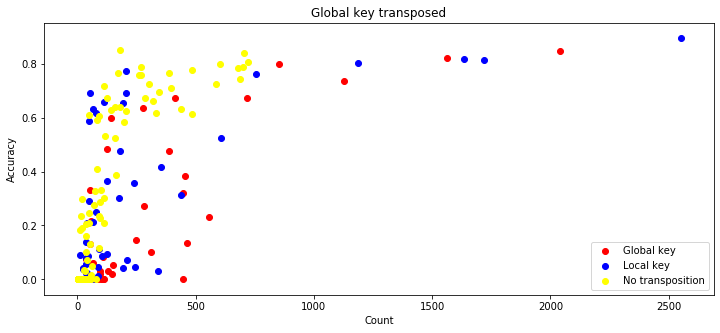

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.scatter(global_counts['count'], global_counts['mean'], color='red', label='Global key')
plt.scatter(local_counts['count'], local_counts['mean'], color='blue', label='Local key')
plt.scatter(none_counts['count'], none_counts['mean'], color='yellow', label='No transposition')
plt.title('Global key transposed')
plt.xlabel('Count')
plt.ylabel('Accuracy')
plt.legend()
plt.show()